In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta


In [2]:
data_inicial = "2013-01-01"
data_final = "2023-01-01"


url = f"https://olinda.bcb.gov.br/olinda/servico/PTAX/versao/v1/odata/CotacaoDolarPeriodo(dataInicial=@dataInicial,dataFinalCotacao=@dataFinalCotacao)?@dataInicial='01-01-2015'&@dataFinalCotacao='01-01-2025'&$top=10000&$format=json&$select=cotacaoVenda,dataHoraCotacao"


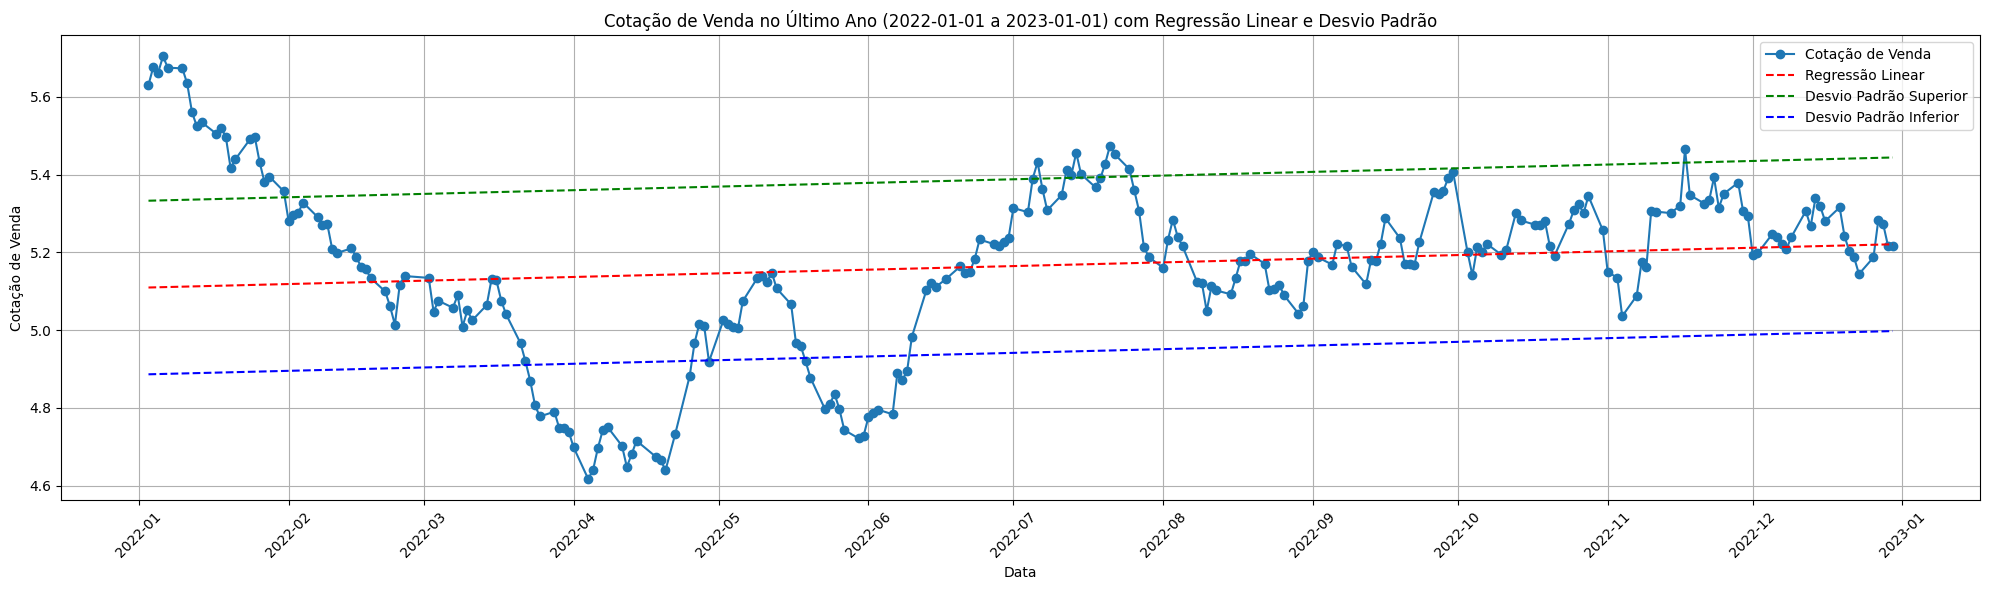

In [3]:
# Requisição da API
response = requests.get(url)
dados = response.json()

# Converte os dados para um DataFrame
df = pd.DataFrame(dados["value"])

# Verifica se há dados
if df.empty:
    raise ValueError("Nenhum dado foi retornado pela API.")

# Extraindo apenas a parte da data e convertendo para datetime
df['data'] = pd.to_datetime(df['dataHoraCotacao'].str.split().str[0])

# Converte as datas para valores numéricos (necessário para np.polyfit)
df['data_num'] = mdates.date2num(df['data'])

# Converter data_final para datetime
data_final_dt = pd.to_datetime(data_final)

# Calcular a data de um ano atrás em relação à data_final
um_ano_atras = data_final_dt - timedelta(days=365)

# Filtrar o DataFrame para incluir apenas os dados do último ano em relação à data_final
df_filtrado = df[(df['data'] >= um_ano_atras) & (df['data'] <= data_final_dt)]

# Verifica se há dados após a filtragem
if df_filtrado.empty:
    raise ValueError("Nenhum dado encontrado no último ano em relação à data_final.")

# Realizar a regressão linear nos dados filtrados
coef = np.polyfit(df_filtrado['data_num'], df_filtrado['cotacaoVenda'], 1)
poly1d_fn = np.poly1d(coef)

# Calcula o desvio padrão da cotação de venda (apenas nos dados filtrados)
std_dev = df_filtrado['cotacaoVenda'].std()

# Criando o gráfico
plt.figure(figsize=(20, 6))

# Plotando os pontos reais
plt.plot(df_filtrado['data'], df_filtrado['cotacaoVenda'], label="Cotação de Venda", marker='o', linestyle='-')

# Adicionando a linha de regressão
plt.plot(df_filtrado['data'], poly1d_fn(df_filtrado['data_num']), color='red', linestyle='--', label="Regressão Linear")

# Adicionando as linhas de desvio padrão
plt.plot(df_filtrado['data'], poly1d_fn(df_filtrado['data_num']) + std_dev, color='green', linestyle='--', label="Desvio Padrão Superior")
plt.plot(df_filtrado['data'], poly1d_fn(df_filtrado['data_num']) - std_dev, color='blue', linestyle='--', label="Desvio Padrão Inferior")

# Formatando o eixo X para exibir os meses
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Mostrar por mês
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Formato da data

# Adicionando título e rótulos
plt.title(f'Cotação de Venda no Último Ano ({um_ano_atras.strftime("%Y-%m-%d")} a {data_final_dt.strftime("%Y-%m-%d")}) com Regressão Linear e Desvio Padrão')
plt.xlabel('Data')
plt.ylabel('Cotação de Venda')
plt.legend()

# Exibindo o gráfico
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [4]:
# Criando logica para contar quantas vezes a linha toca os desvios padrao 
print(df_filtrado.head())

      cotacaoVenda          dataHoraCotacao       data  data_num
1755        5.6309  2022-01-03 13:11:50.357 2022-01-03   18995.0
1756        5.6776  2022-01-04 13:08:59.123 2022-01-04   18996.0
1757        5.6628  2022-01-05 13:07:53.094 2022-01-05   18997.0
1758        5.7042  2022-01-06 13:09:47.715 2022-01-06   18998.0
1759        5.6753  2022-01-07 13:02:38.206 2022-01-07   18999.0


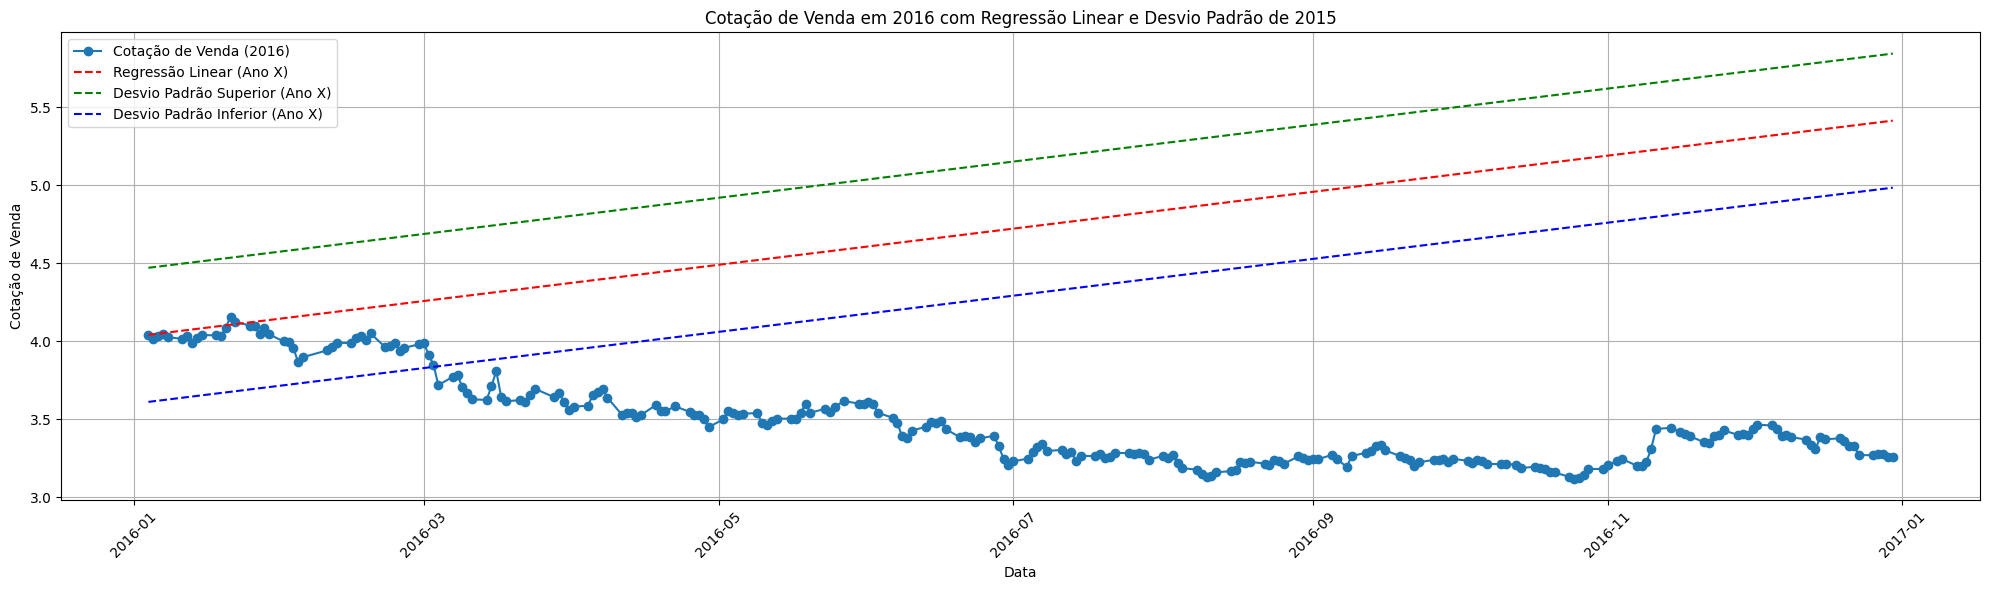

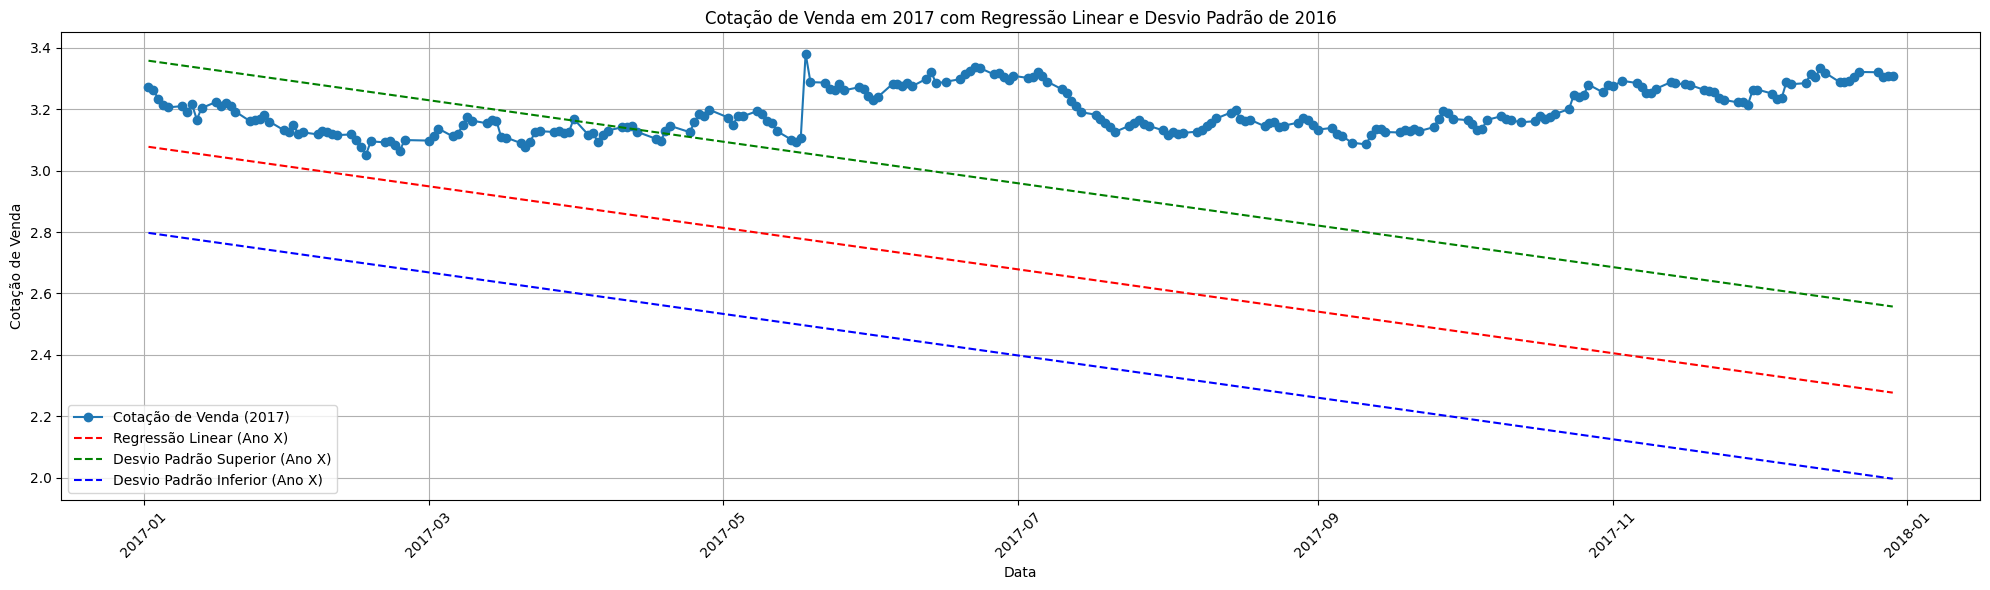

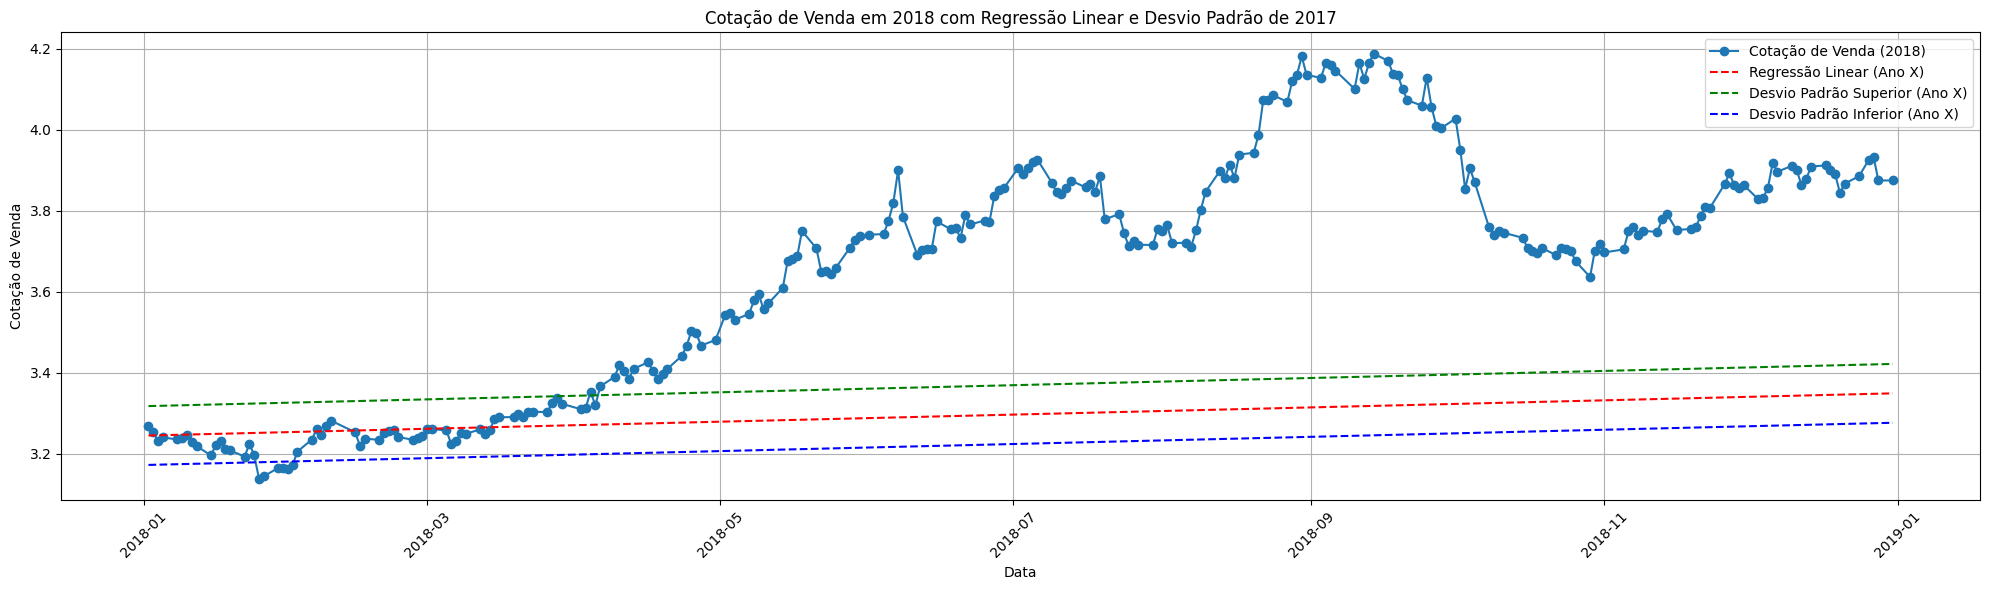

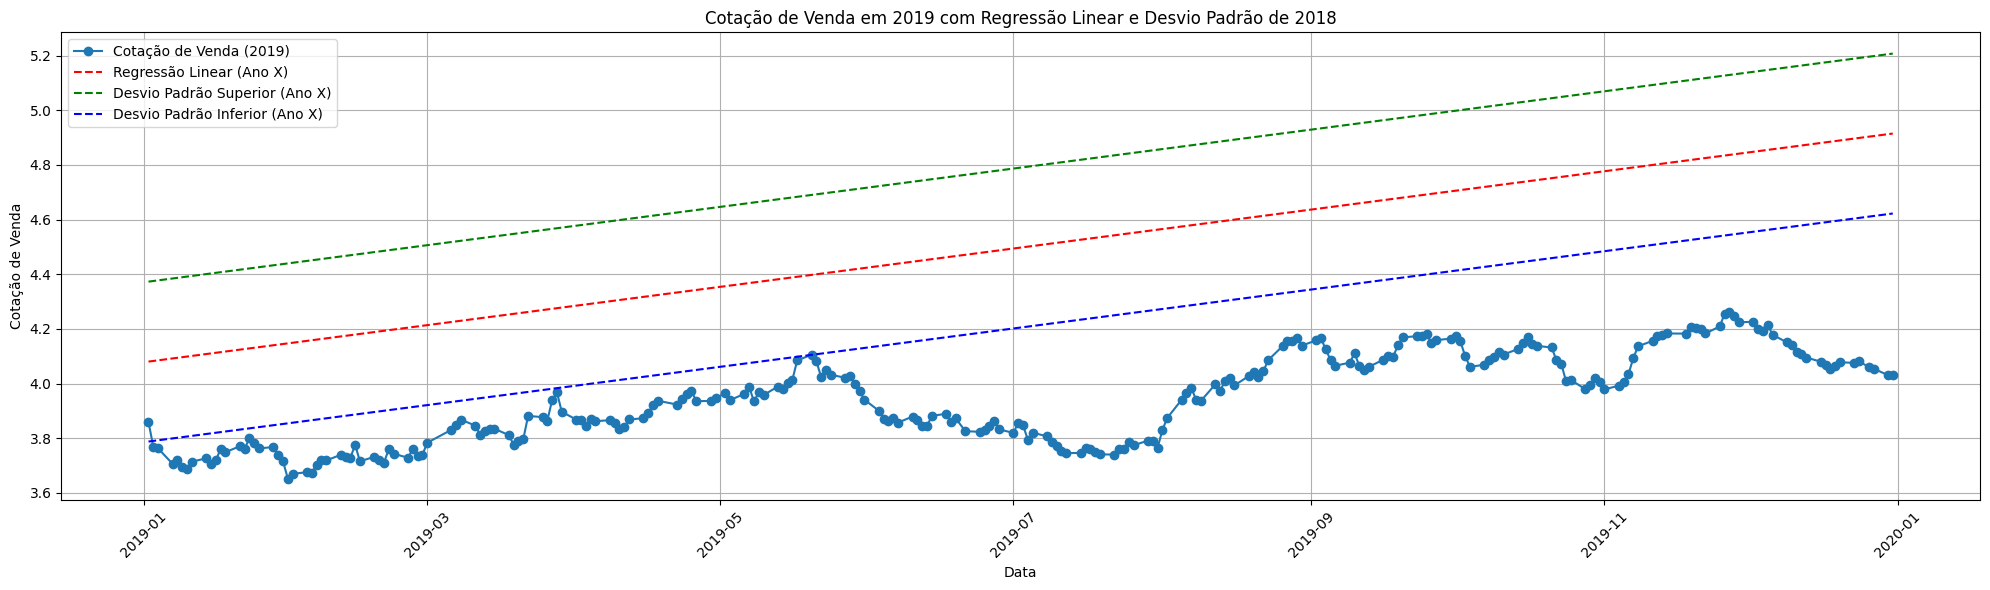

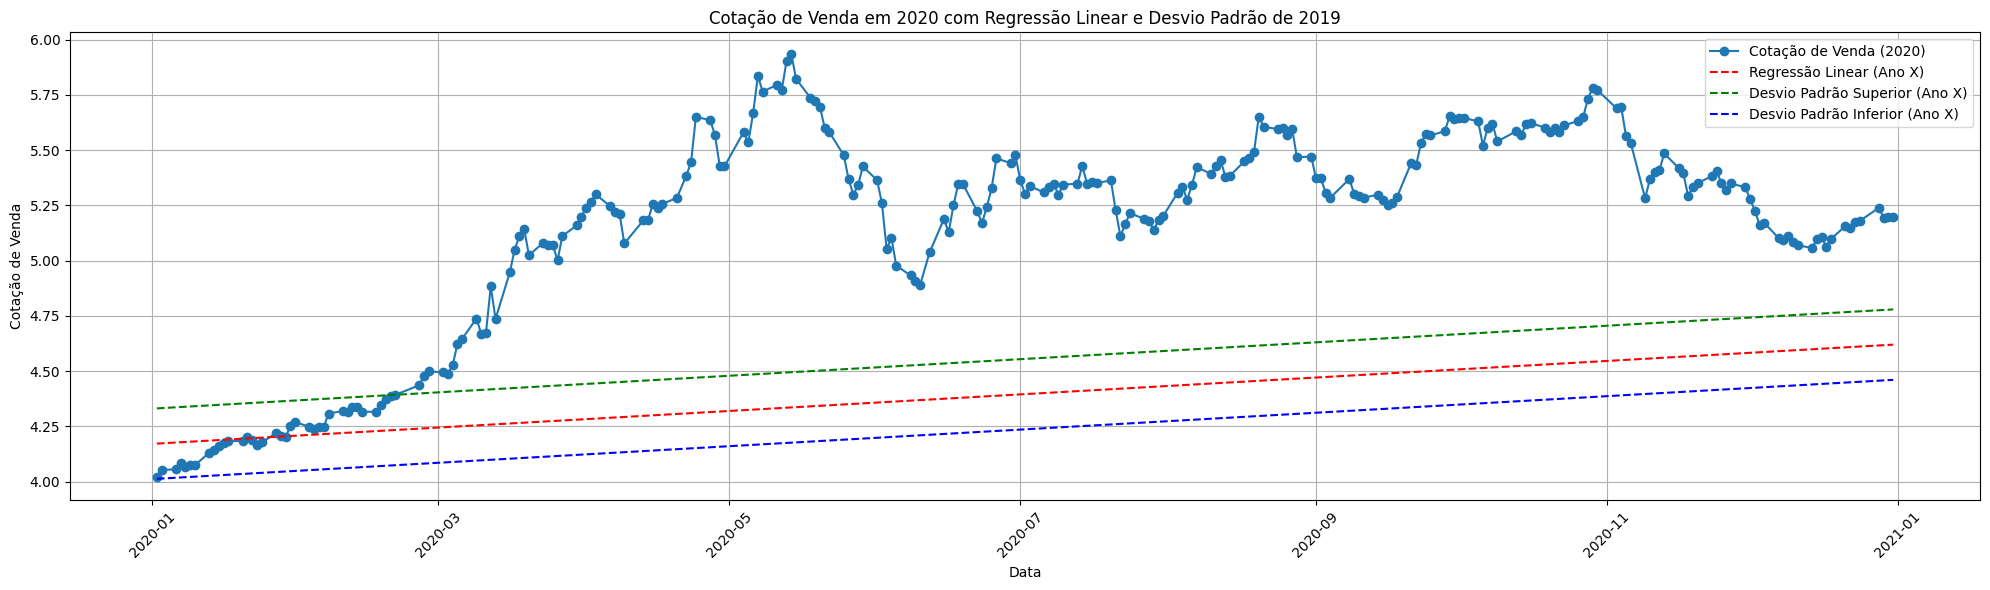

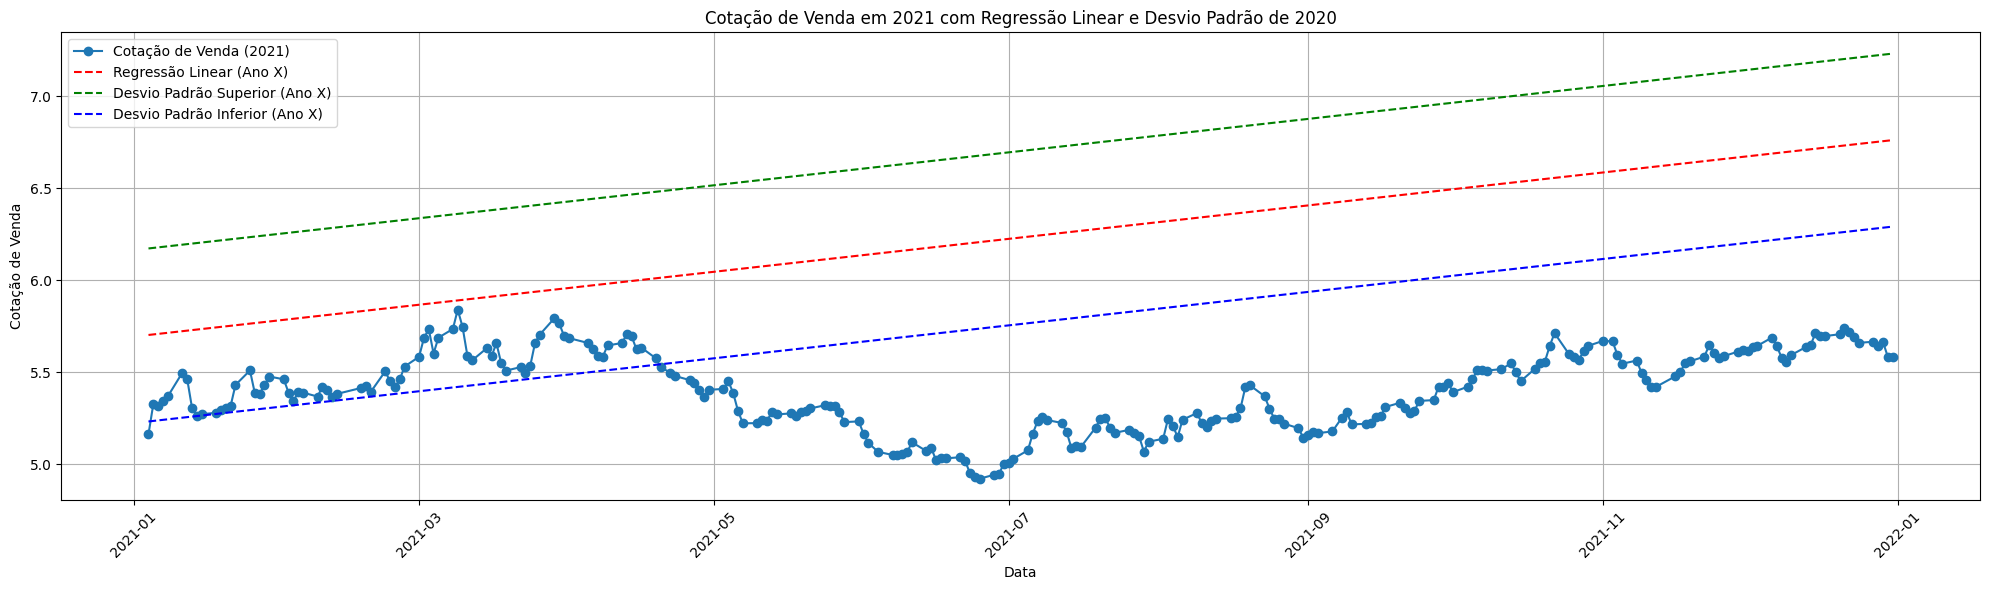

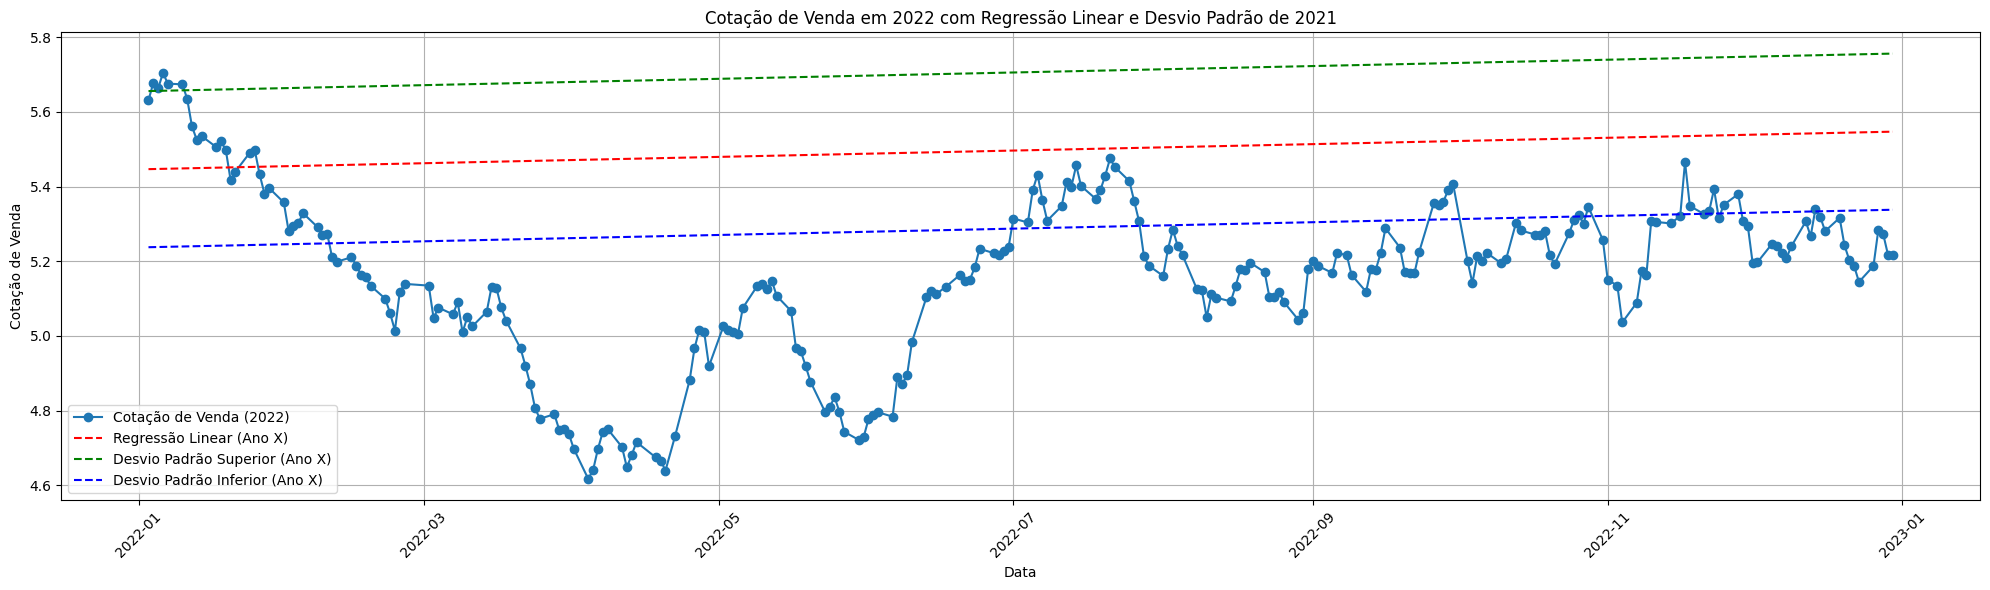

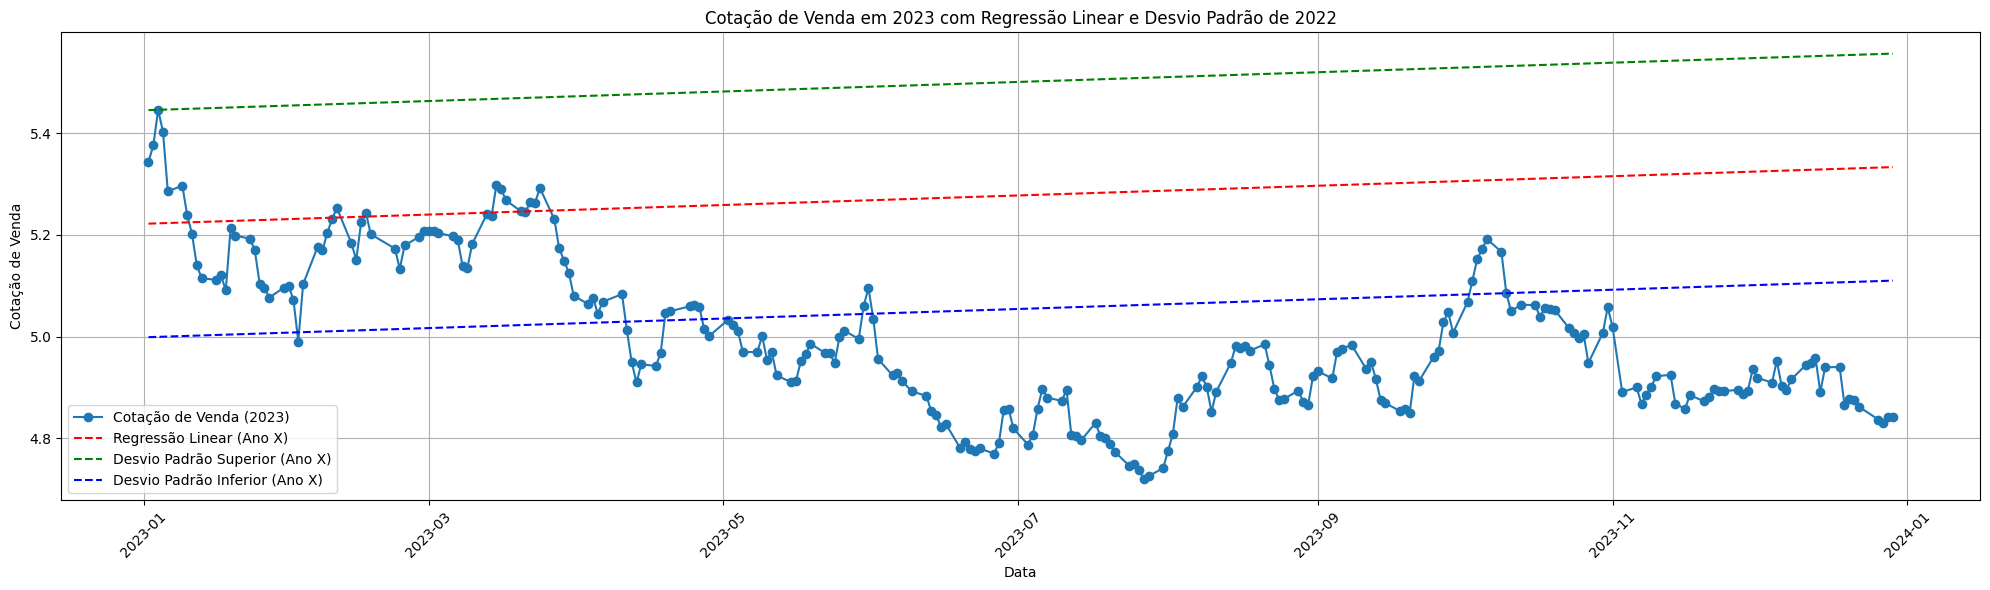

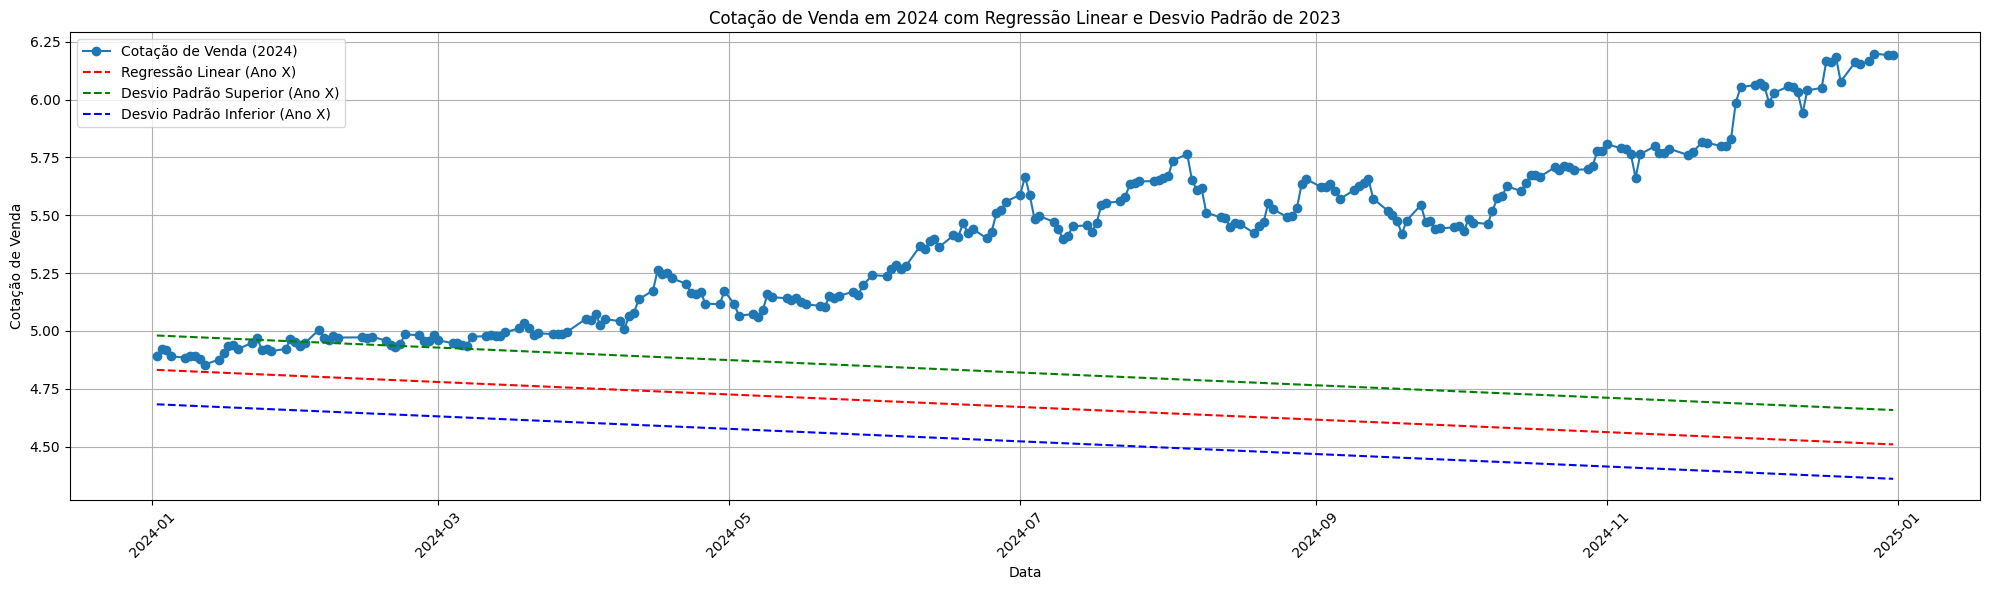

Não há dados suficientes para o ano 2024 ou 2025.
   Ano X  Ano X+1  Tocou Superior  Tocou Inferior  Total Tocou
0   2015     2016               0             209          209
1   2016     2017             179               0          179
2   2017     2018             186               6          192
3   2018     2019               0             251          251
4   2019     2020             214               0          214
5   2020     2021               0             179          179
6   2021     2022               5             190          195
7   2022     2023               1             169          170
8   2023     2024             230               0          230


In [6]:
# Função para contar toques nos desvios padrão
def contar_tocues(df_ano_X, df_ano_X1):
    # Calcular a regressão linear e o desvio padrão no ano X
    coef = np.polyfit(df_ano_X['data_num'], df_ano_X['cotacaoVenda'], 1)
    poly1d_fn = np.poly1d(coef)
    std_dev = df_ano_X['cotacaoVenda'].std()

    # Aplicar a regressão linear e o desvio padrão do ano X aos dados do ano X+1
    valores_previstos = poly1d_fn(df_ano_X1['data_num'])
    limite_superior = valores_previstos + std_dev
    limite_inferior = valores_previstos - std_dev

    # Verificar quantas vezes o preço toca ou ultrapassa os limites no ano X+1
    tocou_superior = df_ano_X1['cotacaoVenda'] > limite_superior
    tocou_inferior = df_ano_X1['cotacaoVenda'] < limite_inferior

    # Contar os toques
    num_tocou_superior = tocou_superior.sum()
    num_tocou_inferior = tocou_inferior.sum()
    total_tocou = num_tocou_superior + num_tocou_inferior

    return num_tocou_superior, num_tocou_inferior, total_tocou, poly1d_fn, std_dev

# Lista para armazenar os resultados de cada ano
resultados = []

# Iterar sobre os anos de 2015 a 2024
for ano in range(2015, 2025):
    # Definir o intervalo do ano X
    inicio_ano_X = pd.to_datetime(f"{ano}-01-01")
    fim_ano_X = pd.to_datetime(f"{ano}-12-31")

    # Definir o intervalo do ano X+1
    inicio_ano_X1 = pd.to_datetime(f"{ano+1}-01-01")
    fim_ano_X1 = pd.to_datetime(f"{ano+1}-12-31")

    # Filtrar os dados para o ano X
    df_ano_X = df[(df['data'] >= inicio_ano_X) & (df['data'] <= fim_ano_X)]

    # Filtrar os dados para o ano X+1
    df_ano_X1 = df[(df['data'] >= inicio_ano_X1) & (df['data'] <= fim_ano_X1)]

    # Verificar se há dados nos anos X e X+1
    if df_ano_X.empty or df_ano_X1.empty:
        print(f"Não há dados suficientes para o ano {ano} ou {ano+1}.")
        continue

    # Contar os toques nos desvios padrão
    num_tocou_superior, num_tocou_inferior, total_tocou, poly1d_fn, std_dev = contar_tocues(df_ano_X, df_ano_X1)

    # Armazenar os resultados
    resultados.append({
        'Ano X': ano,
        'Ano X+1': ano + 1,
        'Tocou Superior': num_tocou_superior,
        'Tocou Inferior': num_tocou_inferior,
        'Total Tocou': total_tocou
    })

    # Plotar o gráfico para o ano X+1
    plt.figure(figsize=(20, 6))
    plt.plot(df_ano_X1['data'], df_ano_X1['cotacaoVenda'], label=f"Cotação de Venda ({ano+1})", marker='o', linestyle='-')
    plt.plot(df_ano_X1['data'], poly1d_fn(df_ano_X1['data_num']), color='red', linestyle='--', label="Regressão Linear (Ano X)")
    plt.plot(df_ano_X1['data'], poly1d_fn(df_ano_X1['data_num']) + std_dev, color='green', linestyle='--', label="Desvio Padrão Superior (Ano X)")
    plt.plot(df_ano_X1['data'], poly1d_fn(df_ano_X1['data_num']) - std_dev, color='blue', linestyle='--', label="Desvio Padrão Inferior (Ano X)")
    plt.title(f'Cotação de Venda em {ano+1} com Regressão Linear e Desvio Padrão de {ano}')
    plt.xlabel('Data')
    plt.ylabel('Cotação de Venda')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Exibir os resultados
resultados_df = pd.DataFrame(resultados)
print(resultados_df)